# This code represents a trading strategy for 1 hour trading intervals
# The predictor is the high price of the XRP cryptocurrency and the minimum threshold is 0.5

In [1]:
################# IMPORTS AND SETUP ##############################


from binance import Client
import pandas as pd
from supporting_functionsM2 import *
from API_KEYS2 import get_keys

# Setting up binance client
KEY, SECRET = get_keys()
client = Client(KEY, SECRET)

# Defining setup variables for creating dataset
# start = "1513724400" # 20.12.2017
start = "1483225200" # 01.01.2017
periods = 101 # approx 8 years
TICKER = "XRPUSDT"
options = ["high", "low", "close", "volume"] # BASE OPTIONS
EPOCHS=5
THRESHOLD=0.5 # Threshold value for lableling, ie. BTCUSDT:close = 0.5 > 0.0 => label = 1, if BTCUSDT:close = -0.5 < 0.0 => 0
PREDICTOR=f"{TICKER}:high"
TIME = f"{TICKER}:time"

In [2]:
################# DOWNLOADING RAW DATA ##########################################

periods = periods
LIMIT = 720 # 720h = 30 days
start1 = start
end1 = next_30_days_unix_timestamp(start1)

############################################ DOWNLOADING DATA ###################################################################### 
data = pd.DataFrame(columns=["time", "open", "high", "low", "close", "volume"])

# downloading the first set of candlestick lines
klines = client.get_historical_klines(TICKER, client.KLINE_INTERVAL_1HOUR, limit=LIMIT, start_str=unix_to_datetime_string(start1, in_milliseconds=False), end_str=unix_to_datetime_string(end1, in_milliseconds=False))
    # print(klines)

# Converting data from list to pandas dataframe
new_data = pd.DataFrame(data=[row[0:6] for row in klines], columns=["time", "open", "high", "low", "close", "volume"])
data = pd.concat([data, new_data], ignore_index=True)

for i in range(periods - 1):
    # Moving the start and end interval to next day
    start1 = next_30_days_unix_timestamp(start1)
    end1 = next_30_days_unix_timestamp(start1) 

    # downloading candlestick lines
    klines = client.get_historical_klines(TICKER, client.KLINE_INTERVAL_1HOUR, limit=LIMIT, start_str=unix_to_datetime_string(start1, in_milliseconds=False), end_str=unix_to_datetime_string(end1, in_milliseconds=False))
    # print(klines)

    # Converting data from list to pandas dataframe
    new_data = pd.DataFrame(data=[row[0:6] for row in klines], columns=["time", "open", "high", "low", "close", "volume"])

    # concatinating the new data with the existing data
    data = pd.concat([data, new_data], ignore_index=True)

# converting all time values from unix to readable string, not important, just for visual purposes and fact checking
data["time"] = data["time"].apply(unix_to_datetime_string) #converting time from 

raw_data = data
display(raw_data)


,time,open,high,low,close,volume
0,2018-05-04 08:00:00,0.50000000,1.50000000,0.50000000,0.92300000,5090857.33000000
1,2018-05-04 09:00:00,0.92300000,0.92850000,0.90100000,0.90199000,3326696.10000000
2,2018-05-04 10:00:00,0.90199000,0.91027000,0.89510000,0.90128000,1176810.48000000
3,2018-05-04 11:00:00,0.90128000,0.92130000,0.88000000,0.91596000,1714233.92000000
4,2018-05-04 12:00:00,0.91596000,0.92450000,0.90000000,0.90098000,1323800.17000000
...,...,...,...,...,...,...
60926,2025-04-18 18:00:00,2.07900000,2.08960000,2.07660000,2.08300000,5359674.10000000
60927,2025-04-18 19:00:00,2.08300000,2.08480000,2.07630000,2.08040000,3894739.40000000
60928,2025-04-18 20:00:00,2.08050000,2.08600000,2.07150000,2.07600000,2277188.30000000
60929,2025-04-18 21:00:00,2.07590000,2.08280000,2.07320000,2.08150000,1962651.80000000


In [3]:
raw_close = raw_data['close'].to_list()
print(f"PERCENT RETURN EVALUATION SET: {round(percent_difference(float(raw_close[-10000]), float(raw_close[-1])), 3)}%")

PERCENT RETURN EVALUATION SET: 275.516%


In [4]:
########################################## PREPROCESSING DATA ####################################################################

# New dataobject for storing processed data
# processed_data = {f"{TICKER}:time": [], f"{TICKER}:open": [], f"{TICKER}:high": [], f"{TICKER}:low": [], f"{TICKER}:close": [], f"{TICKER}:volume": []}
processed_data = {f"{TICKER}:time": [], f"{TICKER}:high": [], f"{TICKER}:low": [], f"{TICKER}:close": [], f"{TICKER}:volume": []}

for i, o in enumerate(raw_data["open"]): #o == open, the open price value of the candle stick
    if i == 0: #Skipping the first hour to calculate the percent diff using this hour
        continue

    if o == 0:
        continue

    processed_data[f"{TICKER}:time"].append(raw_data["time"][i]) #time is the same
    # processed_data[f"{TICKER}:open"].append(percent_difference(float(data["open"][i-1]), float(o))) # percent difference between the opening price of the prior candlestick vs. open of current candle
    processed_data[f"{TICKER}:high"].append(percent_difference(float(o), float(raw_data["high"][i]))) # percent diff between open and high
    processed_data[f"{TICKER}:low"].append(percent_difference(float(o), float(raw_data["low"][i]))) # percent diff between open and low
    processed_data[f"{TICKER}:close"].append(percent_difference(float(o), float(raw_data["close"][i]))) # percent diff between open and close
    processed_data[f"{TICKER}:volume"].append(percent_difference(float(raw_data["volume"][i-1]), float(raw_data["volume"][i]))) # percent difference between the colume of the prior candlestick vs. open of current candle


# processed_data = pd.DataFrame(data=processed_data, columns=[f"{TICKER}:time", f"{TICKER}:open", f"{TICKER}:high", f"{TICKER}:low", f"{TICKER}:close", f"{TICKER}:volume"])
processed_data = pd.DataFrame(data=processed_data, columns=[f"{TICKER}:time", f"{TICKER}:high", f"{TICKER}:low", f"{TICKER}:close", f"{TICKER}:volume"])
display(processed_data)

,XRPUSDT:time,XRPUSDT:high,XRPUSDT:low,XRPUSDT:close,XRPUSDT:volume
0,2018-05-04 09:00:00,0.595883,-2.383532,-2.276273,-34.653519
1,2018-05-04 10:00:00,0.917970,-0.763867,-0.078715,-64.625248
2,2018-05-04 11:00:00,2.221285,-2.361086,1.628795,45.667799
3,2018-05-04 12:00:00,0.932355,-1.742434,-1.635443,-22.775990
4,2018-05-04 13:00:00,0.981121,-1.221962,-0.420639,-4.963754
...,...,...,...,...,...
60925,2025-04-18 18:00:00,0.509861,-0.115440,0.192400,60.957516
60926,2025-04-18 19:00:00,0.086414,-0.321651,-0.124820,-27.332533
60927,2025-04-18 20:00:00,0.264360,-0.432588,-0.216294,-41.531690
60928,2025-04-18 21:00:00,0.332386,-0.130064,0.269763,-13.812494


In [5]:
############################# STATISTICAL ANALYSIS OF PROCESSED DATA #######################################
import statistics as st

high_data_processed = processed_data[f"{TICKER}:high"].to_list()
high_data_processed = high_data_processed[:-10000]
print(f"TOTAL DATAPOINTS: {len(high_data_processed)}")
print(f"MEAN HIGH: {st.mean(high_data_processed)}")
print(f"MEDIAN HIGH: {st.median(high_data_processed)}")

print(f"MAX HIGH IN DATASET: {max(high_data_processed)}")
print(f"OCCURRENCES OVER 0.5: {sum(x > 0.5 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.5 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.6: {sum(x > 0.6 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.6 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.7: {sum(x > 0.7 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.7 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.8: {sum(x > 0.8 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.8 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.9: {sum(x > 0.9 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.9 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 1: {sum(x > 1 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 1 for x in high_data_processed) / len(high_data_processed), 2)}%")
print("----------------------------------------------------------------------")

print("EVALUATION DATASET STATISTICS")
high_data_processed = processed_data[f"{TICKER}:high"].to_list()
high_data_processed = high_data_processed[-10000:]
print(f"TOTAL DATAPOINTS: {len(high_data_processed)}")
print(f"MEAN HIGH: {st.mean(high_data_processed)}")
print(f"MEDIAN HIGH: {st.median(high_data_processed)}")

print(f"MAX HIGH IN DATASET: {max(high_data_processed)}")
print(f"OCCURRENCES OVER 0.5: {sum(x > 0.5 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.5 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.6: {sum(x > 0.6 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.6 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.7: {sum(x > 0.7 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.7 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.8: {sum(x > 0.8 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.8 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.9: {sum(x > 0.9 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.9 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 1: {sum(x > 1 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 1 for x in high_data_processed) / len(high_data_processed), 2)}%")
print("----------------------------------------------------------------------")

TOTAL DATAPOINTS: 50930
MEAN HIGH: 0.6775703037886924
MEDIAN HIGH: 0.39900714748500443
MAX HIGH IN DATASET: 36.684266103484696
OCCURRENCES OVER 0.5: 21180 - PERCENT OF DATASET: 0.42%
OCCURRENCES OVER 0.6: 17784 - PERCENT OF DATASET: 0.35%
OCCURRENCES OVER 0.7: 15063 - PERCENT OF DATASET: 0.3%
OCCURRENCES OVER 0.8: 12751 - PERCENT OF DATASET: 0.25%
OCCURRENCES OVER 0.9: 10898 - PERCENT OF DATASET: 0.21%
OCCURRENCES OVER 1: 9406 - PERCENT OF DATASET: 0.18%
----------------------------------------------------------------------
EVALUATION DATASET STATISTICS
TOTAL DATAPOINTS: 10000
MEAN HIGH: 0.6669494513946251
MEDIAN HIGH: 0.38967763296090563
MAX HIGH IN DATASET: 22.40589345072321
OCCURRENCES OVER 0.5: 4125 - PERCENT OF DATASET: 0.41%
OCCURRENCES OVER 0.6: 3519 - PERCENT OF DATASET: 0.35%
OCCURRENCES OVER 0.7: 2962 - PERCENT OF DATASET: 0.3%
OCCURRENCES OVER 0.8: 2528 - PERCENT OF DATASET: 0.25%
OCCURRENCES OVER 0.9: 2175 - PERCENT OF DATASET: 0.22%
OCCURRENCES OVER 1: 1901 - PERCENT OF DA

In [6]:
########################### LABELING THE DATA ##################################


# column_labels = ["BTCUSDT:time"] # name of the columns for the return dataframe
column_labels = ["time"] # name of the columns for the return dataframe

# filling up the list with labels for the columns
for roundd in range(EPOCHS):
    for option in options:
        column_labels.append(f"{TICKER}:{option}{roundd}")

column_labels.append("Label")


# filling up list of data, row by row in the dataset
labelled_data_rows = [] # this list stores all the rows filled with all the data
for i in range(len(processed_data[TIME]) - EPOCHS): #looping from the third element to the third last element, with stepsize 1, if epoch=3
    data_row = []

    data_row.append(processed_data[TIME][i + EPOCHS - 1])

    for t in range(EPOCHS):
        for option in options:
            data_row.append(processed_data[f"{TICKER}:{option}"][i + t])

    if processed_data[PREDICTOR][i + EPOCHS] > THRESHOLD: # here we use the threshold
        data_row.append(1)
    else:
        data_row.append(0)

    labelled_data_rows.append(data_row)


labelled_data_frame = pd.DataFrame(labelled_data_rows, columns=column_labels)
display(labelled_data_frame)

,time,XRPUSDT:high0,XRPUSDT:low0,XRPUSDT:close0,XRPUSDT:volume0,XRPUSDT:high1,XRPUSDT:low1,XRPUSDT:close1,XRPUSDT:volume1,XRPUSDT:high2,...,XRPUSDT:volume2,XRPUSDT:high3,XRPUSDT:low3,XRPUSDT:close3,XRPUSDT:volume3,XRPUSDT:high4,XRPUSDT:low4,XRPUSDT:close4,XRPUSDT:volume4,Label
0,2018-05-04 13:00:00,0.595883,-2.383532,-2.276273,-34.653519,0.917970,-0.763867,-0.078715,-64.625248,2.221285,...,45.667799,0.932355,-1.742434,-1.635443,-22.775990,0.981121,-1.221962,-0.420639,-4.963754,1
1,2018-05-04 14:00:00,0.917970,-0.763867,-0.078715,-64.625248,2.221285,-2.361086,1.628795,45.667799,0.932355,...,-22.775990,0.981121,-1.221962,-0.420639,-4.963754,0.777361,-0.321859,0.539030,-16.004397,0
2,2018-05-04 15:00:00,2.221285,-2.361086,1.628795,45.667799,0.932355,-1.742434,-1.635443,-22.775990,0.981121,...,-4.963754,0.777361,-0.321859,0.539030,-16.004397,0.185325,-2.738814,-1.912065,55.272929,1
3,2018-05-04 16:00:00,0.932355,-1.742434,-1.635443,-22.775990,0.981121,-1.221962,-0.420639,-4.963754,0.777361,...,-16.004397,0.185325,-2.738814,-1.912065,55.272929,1.618196,-0.645015,1.214213,-49.288847,1
4,2018-05-04 17:00:00,0.981121,-1.221962,-0.420639,-4.963754,0.777361,-0.321859,0.539030,-16.004397,0.185325,...,55.272929,1.618196,-0.645015,1.214213,-49.288847,0.548609,-1.239120,-1.204483,-21.089498,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60920,2025-04-18 17:00:00,0.004806,-0.595925,-0.201845,2.029900,0.197438,-0.399692,-0.134836,18.175418,0.207349,...,20.733701,0.466382,-0.160319,0.349786,-58.042147,0.721340,-0.183966,0.643881,62.986995,1
60921,2025-04-18 18:00:00,0.197438,-0.399692,-0.134836,18.175418,0.207349,-0.839039,-0.747420,20.733701,0.466382,...,-58.042147,0.721340,-0.183966,0.643881,62.986995,0.509861,-0.115440,0.192400,60.957516,0
60922,2025-04-18 19:00:00,0.207349,-0.839039,-0.747420,20.733701,0.466382,-0.160319,0.349786,-58.042147,0.721340,...,62.986995,0.509861,-0.115440,0.192400,60.957516,0.086414,-0.321651,-0.124820,-27.332533,0
60923,2025-04-18 20:00:00,0.466382,-0.160319,0.349786,-58.042147,0.721340,-0.183966,0.643881,62.986995,0.509861,...,60.957516,0.086414,-0.321651,-0.124820,-27.332533,0.264360,-0.432588,-0.216294,-41.531690,0


# Model Training

This code block divides the dataset into a training dataset and trains a new model using the **AutoGluon Tabular** predictor.

In [7]:
################################ TRAINING NEW MODEL #######################################
from autogluon.tabular import TabularDataset, TabularPredictor

# defining training size and colums to use for training within the labelled dataset
VALIDATION_SIZE = 10000
columns_to_use = [f"{TICKER}:high0", f"{TICKER}:low0", f"{TICKER}:close0", f"{TICKER}:volume0", f"{TICKER}:high1", f"{TICKER}:low1", f"{TICKER}:close1", f"{TICKER}:volume1", f"{TICKER}:high2", f"{TICKER}:low2", f"{TICKER}:close2", f"{TICKER}:volume2", f"{TICKER}:high3", f"{TICKER}:low3", f"{TICKER}:close3", f"{TICKER}:volume3", f"{TICKER}:high4", f"{TICKER}:low4", f"{TICKER}:close4", f"{TICKER}:volume4", "Label"]
LABEL = "Label"

# defining training data
training_dataframe = labelled_data_frame.iloc[:-VALIDATION_SIZE].copy()
train_data_frame2 = training_dataframe[columns_to_use]
train_tabular_dataset = TabularDataset(train_data_frame2)

# # Training model -> TabularPredictor
# predictor = TabularPredictor(label=label, eval_metric="balanced_accuracy", positive_class=1).fit(train_tabular_dataset, num_bag_folds=5, num_bag_sets=5, num_stack_levels=3)
# predictor = TabularPredictor(label=label, eval_metric="accuracy").fit(train_tabular_dataset, presets="high_quality")
predictor = TabularPredictor(label=LABEL).fit(train_tabular_dataset)



c:\Users\47981\Desktop\MasterThesis\Repo\MasterThesis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No path specified. Models will be saved in: "AutogluonModels\ag-20250603_092636"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       4.19 GB / 15.92 GB (26.3%)
Disk Space Avail:   136.90 GB / 475.69 GB (28.8%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Defau

# Model Evaluation

This code block divides the dataset into a validation dataset and evaluates the model using the **AutoGluons** inbuilt evaluation library. In addition the model is backtested using the validation set to measure its performance and calulate its "expected return" over the period.

In [8]:
#################### MODEL EVALUATION ################################

# Defining the testing set using the training size and columns to use
testing_dataframe = labelled_data_frame.tail(VALIDATION_SIZE).copy()
#display(testing_dataframe)
test_data_frame2 = testing_dataframe[columns_to_use]
test_tabular_dataset = TabularDataset(test_data_frame2)

######## Making predictions
y_pred = predictor.predict(test_tabular_dataset.drop(columns=[LABEL]))
display(y_pred)


#### Evaluation
eval_report = predictor.evaluate(test_tabular_dataset, detailed_report=True)
display(eval_report)

feature_importance = predictor.feature_importance(test_tabular_dataset)
display(feature_importance)


50925    0
50926    0
50927    0
50928    1
50929    0
        ..
60920    0
60921    0
60922    0
60923    0
60924    0
Name: Label, Length: 10000, dtype: int64

{'accuracy': 0.699,
 'balanced_accuracy': 0.6742179239200516,
 'mcc': 0.36538531230842014,
 'roc_auc': 0.7560154738878144,
 'f1': 0.5934629929767693,
 'precision': 0.6700213479719427,
 'recall': 0.5326060606060606,
 'confusion_matrix':       0     1
 0  4793  1082
 1  1928  2197,
 'classification_report': {'0': {'precision': 0.7131379259038834,
   'recall': 0.8158297872340425,
   'f1-score': 0.7610352492854875,
   'support': 5875.0},
  '1': {'precision': 0.6700213479719427,
   'recall': 0.5326060606060606,
   'f1-score': 0.5934629929767693,
   'support': 4125.0},
  'accuracy': 0.699,
  'macro avg': {'precision': 0.691579636937913,
   'recall': 0.6742179239200516,
   'f1-score': 0.6772491211311285,
   'support': 10000.0},
  'weighted avg': {'precision': 0.6953523375069578,
   'recall': 0.699,
   'f1-score': 0.6919116935581413,
   'support': 10000.0}}}

Computing feature importance via permutation shuffling for 20 features using 5000 rows with 5 shuffle sets...
	2.0s	= Expected runtime (0.4s per shuffle set)
	0.71s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
XRPUSDT:high4,3.180000e-02,0.005083,0.000076,5,0.042267,0.021333
XRPUSDT:low4,2.880000e-02,0.005036,0.000108,5,0.039169,0.018431
XRPUSDT:low3,6.080000e-03,0.002816,0.004239,5,0.011879,0.000281
XRPUSDT:low0,4.720000e-03,0.003991,0.028664,5,0.012939,-0.003499
XRPUSDT:high3,4.600000e-03,0.003760,0.026076,5,0.012343,-0.003143
XRPUSDT:close4,4.000000e-03,0.003280,0.026311,5,0.010754,-0.002754
XRPUSDT:high1,4.000000e-03,0.003326,0.027344,5,0.010848,-0.002848
XRPUSDT:high2,3.280000e-03,0.004728,0.097885,5,0.013015,-0.006455
XRPUSDT:low2,2.640000e-03,0.003067,0.063300,5,0.008956,-0.003676
XRPUSDT:low1,2.240000e-03,0.003817,0.129828,5,0.010099,-0.005619


In [ ]:
import re
import pandas as pd

METRIC_RE = re.compile(r":([a-zA-Z]+?)(\d+)$")   # capture metric & hour suffix


def analyze_feature_importance(feature_names, importances):
    """
    Print a short report on a model’s feature-importance vector.

    Parameters
    ----------
    feature_names : list[str]
        All feature names, e.g. ["SOLUSDT:high4", "SOLUSDT:low2", ...]
    importances : list[float]
        Matching importance values, same length/order as `feature_names`
    """
    if len(feature_names) != len(importances):
        raise ValueError("feature_names and importances must be the same length!")

    # ── Build a DataFrame ────────────────────────────────────────────────────
    df = pd.DataFrame(
        {"feature": feature_names, "importance": importances}
    ).assign(
        metric=lambda d: d["feature"].str.extract(METRIC_RE)[0].str.lower(),
        hour=lambda d: pd.to_numeric(
            d["feature"].str.extract(METRIC_RE)[1], errors="coerce"
        ),
    )

    # Drop rows we could not parse
    df = df.dropna(subset=["metric", "hour"]).copy()
    df["hour"] = df["hour"].astype(int)

    # ── 1. % of positive importances ────────────────────────────────────────
    pct_pos = (df["importance"] > 0).mean() * 100

    # ── 2. Rank by hour (sum of importances per lag) ────────────────────────
    hour_scores = df.groupby("hour")["importance"].sum().sort_values(ascending=False)
    hour_ranking = hour_scores.index.tolist()

    # ── 3. Rank by metric (sum of importances per metric) ───────────────────
    metric_scores = (
        df.groupby("metric")["importance"].sum().sort_values(ascending=False)
    )
    metric_ranking = metric_scores.index.tolist()

    # ── Report ──────────────────────────────────────────────────────────────
    print(f"{pct_pos:.1f}% of the {len(df)} features have **positive** importance.\n")

    print("Ranking by HOUR (most → least important):")
    for i, h in enumerate(hour_ranking, 1):
        print(f"  {i}. h{h:<1}   sum importance = {hour_scores[h]:.6f}")

    print("\nRanking by METRIC (most → least important):")
    for i, m in enumerate(metric_ranking, 1):
        print(f"  {i}. {m:<6} sum importance = {metric_scores[m]:.6f}")

    top_features = (
        df.loc[df["importance"].abs().sort_values(ascending=False).index]
        .head(5)[["feature", "importance"]]
    )
    print("\nTop 5 individual features:")
    for feat, imp in top_features.itertuples(index=False):
        print(f"  {feat:<25} {imp:.6f}")




analyze_feature_importance(feature_importance.index.to_list(), feature_importance['importance'].to_list())

In [9]:
# ANALYSIS OF PREDICTIONS AND PROBABILITIES

import statistics as st

# making and processing probabilities from evaluation dataset
y_prob = predictor.predict_proba(test_tabular_dataset.drop(columns=[LABEL]))

validation_probabilities = pd.DataFrame(y_prob).reset_index(drop=True) # probability for each prediction
validation_predictions = pd.DataFrame(y_pred).reset_index(drop=True)
validation_dataset = pd.DataFrame(test_data_frame2).reset_index(drop=True)
#display(validation_probabilities)
#display(validation_predictions)
#display(validation_dataset)

print(f"MEAN PROB 1 CLASSIFICATION: {st.mean(validation_probabilities[1].to_list())}")
print(f"MAX PROB 1 CLASSIFICATION: {max(validation_probabilities[1].to_list())}")
print(f"MIN PROB 1 CLASSIFICATION: {min(validation_probabilities[1].to_list())}")

count_above_07 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.7)
print("COUNT OF NUMBERS > 0.7:", count_above_07)

count_above_08 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.8)
print("COUNT OF NUMBERS > 0.8:", count_above_08)

count_above_09 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.9)
print("COUNT OF NUMBERS > 0.9:", count_above_09)








MEAN PROB 1 CLASSIFICATION: 0.4135711058489978
MAX PROB 1 CLASSIFICATION: 0.8706400990486145
MIN PROB 1 CLASSIFICATION: 0.12072597444057465
COUNT OF NUMBERS > 0.7: 722
COUNT OF NUMBERS > 0.8: 113
COUNT OF NUMBERS > 0.9: 0


NUMBER OF TRADES: 722
ACCURACY: 78.25%
RETURN: 1.04%
SHARP RATIO: 0.19996120300992873
SHARP RATIO ONLY HOLDING ASSET: 1.8632330989062431
MEAN RETURN BAD TRADES: -1.757656050955414
----------------------------------
-0.943
-2.256
-0.287
0.015
-1.541
-0.723
-1.566
0.184
-3.202
-0.763
0.086
-0.099
-1.253
-0.635
-1.037
-2.003
-1.446
-0.049
-0.259
-0.266
-4.506
-2.648
-0.788
-2.861
0.089
-2.184
-2.649
0.131
-0.757
-0.791
-1.097
-1.17
-2.602
-1.634
-0.631
-3.052
-2.059
-3.526
-0.307
-0.544
-0.822
-4.773
-0.723
-4.323
-0.479
-2.206
-2.337
-1.652
-2.122
-1.2
-2.417
-2.949
-2.316
-1.009
-2.67
-3.891
-1.46
-2.351
-0.173
-0.78
-0.731
-0.546
-4.24
-0.925
-2.358
-1.472
-1.42
-1.745
-1.446
-0.785
-1.88
-1.008
-0.115
-0.801
-4.302
-4.162
-2.832
-10.484
-1.026
-3.669
-1.479
-0.237
-5.288
0.046
-4.935
-1.423
-0.453
-2.299
-1.781
-0.027
-5.416
-0.262
-7.271
-0.617
-3.395
-0.21
-1.73
-0.111
-0.816
-2.801
-0.705
-0.099
-2.752
-1.065
-0.993
0.377
0.156
-0.861
0.003
-3.019
-5.35
-1.191
0.092
-1.247
-0.626
-

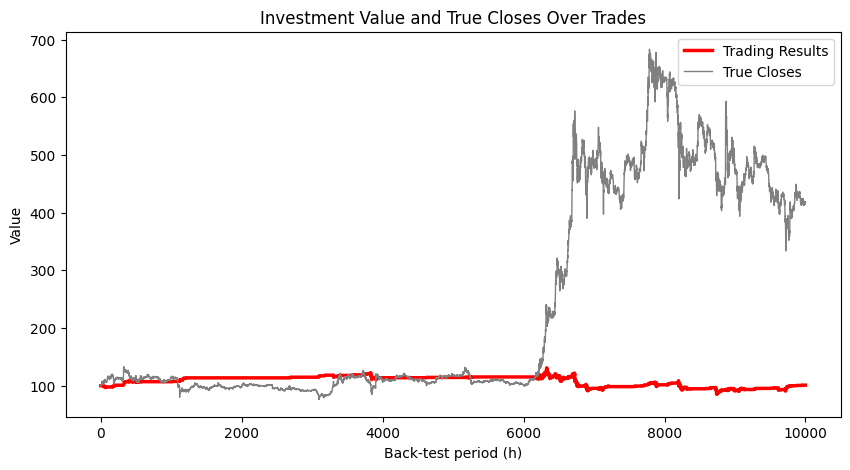

In [10]:
import matplotlib.pyplot as plt

# --- Constants ---
MINIMUM_PROBABILITY = 0.7
LEVERAGE = 1
FEE = 0.0
GAIN = 0.5 - FEE  # Interpreted as a percentage (e.g., 0.5% if multiplied by /100)


# --- Tracking variables ---
correct_trades = 0
total_trades = 0
bad_trades = []
all_trades = []

initial_investment = 100
current_investment = initial_investment
investment_history = []

# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        total_trades += 1
        
        # Check if the prediction was correct
        if validation_predictions["Label"][idx] == validation_dataset["Label"][idx]:
            correct_trades += 1
            
            # Record the "gain" in your trade list
            all_trades.append(GAIN * LEVERAGE)
            
            # Update current_investment by a factor of (1 + gain%)
            current_investment *= 1 + (GAIN / 100 * LEVERAGE)
        
        else:
            # Grab the next close price; watch out for index out-of-range in real code
            true_close = (validation_dataset[f"{TICKER}:close4"][idx + 1]) - FEE
            
            # Record the trade details
            bad_trades.append(round(true_close * LEVERAGE, 3))
            all_trades.append(true_close * LEVERAGE)

            # Update current_investment by (1 + some factor of true_close?)
            current_investment *= 1 + (true_close / 100 * LEVERAGE)
    
    else:
        all_trades.append(0)

    # In all cases, record the current investment amount
    investment_history.append(current_investment)

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0
total_return = current_investment - initial_investment

# --- Print results ---
#print(f"CORRECT: {correct_trades}")
#print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
print(f"ACCURACY: {round(win_rate, 2)}%")
print(f"RETURN: {round(total_return, 2)}%")
#print(f"INVESTMENT VALUE: {round(current_investment, 2)}")
print(f"SHARP RATIO: {calculate_sharpe_ratio(all_trades)}")
sharpe_ratio9999 = calculate_sharpe_ratio(validation_dataset[f"{TICKER}:close4"].to_list())
print(f"SHARP RATIO ONLY HOLDING ASSET: {sharpe_ratio9999}")
print(f"MEAN RETURN BAD TRADES: {st.mean(bad_trades)}")
print("-" * 34)

# Print information about bad trades
for trade in bad_trades:
    print(trade)

# --- Plot the investment history ---
true_closes_list = validation_dataset[f"{TICKER}:close4"].to_list()
true_close_base = 100
true_close_base_list = []

for close in true_closes_list:
    true_close_base *= 1 + (close / 100)
    true_close_base_list.append(true_close_base)


plt.figure(figsize=(10,5))
plt.plot(investment_history, label="Trading Results", color='red', linewidth=2.5)
plt.plot(true_close_base_list, label="True Closes", color='gray', linewidth=1)
plt.xlabel("Back-test period (h)")
plt.ylabel("Value")
plt.title("Investment Value and True Closes Over Trades")
plt.legend()
plt.show()

In [ ]:
############### ANALYSIS OF TRADING USING CLOSING PRICE ################################

# --- Constants ---
MINIMUM_PROBABILITY = 0.8
TRADING_FEE = 0.25

# --- Tracking variables ---
correct_trades = 0
total_trades = 0
wrong_trades = 0

all_trades = []
good_trades = []
bad_trades = []

# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        true_close = validation_dataset[f"{TICKER}:close4"][idx + 1] - TRADING_FEE
        
        if true_close >= 0:
            correct_trades += 1
            good_trades.append(true_close)
        else:
            bad_trades.append(true_close)



        total_trades += 1
        all_trades.append(true_close)
            

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0

# --- Print results ---
print(f"CORRECT: {correct_trades}")
print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
print(f"WIN RATE: {round(win_rate, 2)}%")
print("-" * 34)

print(f"MEAN GOOD TRADES: {st.mean(good_trades)}")
print(f"MEAN BAD TRADES: {st.mean(bad_trades)}")

investtt = 100
investment_history2 = []
for trade in all_trades:
    investtt *= 1 + (trade / 100)
    investment_history2.append(investtt)
    # print(trade)

print(f"RETURN: {round(investtt - 100, 3)} %")

# --- Plot the investment history ---
plt.plot(investment_history2)
plt.xlabel("Trade Index")
plt.ylabel("Investment Value")
plt.title("Investment Value Over Trades")
plt.show()

In [ ]:
############### ANALYSIS OF TRADING USING CLOSING PRICE ################################

# --- Constants ---
MINIMUM_PROBABILITY = 0.8
TRADING_FEE = 0.25
LEVERAGE = 1

# --- Tracking variables ---
correct_trades = 0
total_trades = 0
wrong_trades = 0

all_trades = []
good_trades = []
bad_trades = []
investment_value = 100
investment_history = []


# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        true_close = (validation_dataset[f"{TICKER}:close4"][idx + 1] - TRADING_FEE) * LEVERAGE
        
        if true_close >= 0:
            correct_trades += 1
            good_trades.append(true_close)
        else:
            bad_trades.append(true_close)



        total_trades += 1
        all_trades.append(true_close)

        investment_value *= 1 + (true_close / 100)
        investment_history.append(investment_value)
    
    else:
        investment_history.append(investment_value)

            

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0

# --- Print results ---
print(f"CORRECT: {correct_trades}")
print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
print(f"WIN RATE: {round(win_rate, 2)}%")
print("-" * 34)

print(f"MEAN GOOD TRADES: {st.mean(good_trades)}")
print(f"MEAN BAD TRADES: {st.mean(bad_trades)}")
print(f"INVESTMENT VALUE {investment_value}")

# investtt = 100
# investment_history2 = []
# for trade in all_trades:
#     investtt *= 1 + (trade / 100)
#     investment_history2.append(investtt)
#     # print(trade)

# print(f"RETURN: {round(investtt - 100, 3)} %")


from matplotlib import pyplot as plt
# --- Plot the investment history ---


plt.plot(investment_history)
plt.xlabel("Trade Index")
plt.ylabel("Investment Value")
plt.title("Investment Value Over Trades")
plt.show()